In [34]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [35]:
from sklearn.datasets import load_boston

In [36]:
data = load_boston()

In [37]:
losses = []

In [38]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 148.787
Epoch: 101, Loss: 6.651
Epoch: 201, Loss: 5.648
Epoch: 301, Loss: 4.626
Epoch: 401, Loss: 3.815
Epoch: 501, Loss: 4.293
Epoch: 601, Loss: 4.529
Epoch: 701, Loss: 4.553
Epoch: 801, Loss: 3.963
Epoch: 901, Loss: 3.781
Epoch: 1001, Loss: 3.877
Epoch: 1101, Loss: 3.337
Epoch: 1201, Loss: 3.241
Epoch: 1301, Loss: 3.443
Epoch: 1401, Loss: 3.344
Epoch: 1501, Loss: 3.297
Epoch: 1601, Loss: 2.934
Epoch: 1701, Loss: 3.536
Epoch: 1801, Loss: 3.419
Epoch: 1901, Loss: 3.659
Epoch: 2001, Loss: 3.526
Epoch: 2101, Loss: 3.780
Epoch: 2201, Loss: 3.421
Epoch: 2301, Loss: 3.299
Epoch: 2401, Loss: 3.207
Epoch: 2501, Loss: 3.568
Epoch: 2601, Loss: 2.970
Epoch: 2701, Loss: 3.131
Epoch: 2801, Loss: 2.888
Epoch: 2901, Loss: 2.723
Epoch: 3001, Loss: 3.261
Epoch: 3101, Loss: 3.510
Epoch: 3201, Loss: 2.906
Epoch: 3301, Loss: 3.266
Epoch: 3401, Loss: 3.224
Epoch: 3501, Loss: 2.928
Epoch: 3601, Loss: 3.196
Epoch: 3701, Loss: 3.056
Epoch: 3801, Loss: 2.951
Epoc

In [39]:
topological_sort(feed_dict)

In [51]:
import matplotlib.pyplot as plt

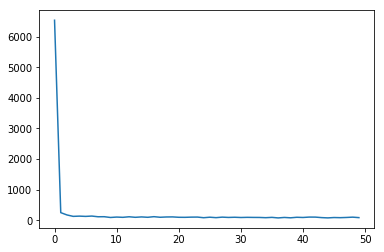

In [54]:
plt.plot(range(len(losses)), losses)

In [18]:
W2.value

array([[  6.06675992],
       [  8.23298865],
       [  8.80431613],
       [-13.36338757],
       [  9.65316777],
       [  5.96190503],
       [ 10.99998584],
       [  3.48275087],
       [  3.78735499],
       [ 12.03614078]])

In [4]:
X_ = data['data']

In [6]:
data = load_boston()
X_ = data['data']
y_ = data['target']

In [5]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [1]:
import keras

Using TensorFlow backend.


In [32]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [32]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=30, activation='sigmoid', input_dim=X_.shape[1]))
model.add(Dense(units=30, activation='sigmoid', input_dim=30))
model.add(Dense(units=30, activation='sigmoid', input_dim=30))
model.add(Dense(units=30, activation='sigmoid', input_dim=30))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [33]:
model.fit(X_, y_, epochs=100, batch_size=128)

Epoch 1/100
506/506 [==============================] - 0s 628us/step - loss: 375.2571 - mean_squared_error: 375.2571
Epoch 2/100
506/506 [==============================] - 0s 11us/step - loss: 100.6066 - mean_squared_error: 100.6066
Epoch 3/100
506/506 [==============================] - 0s 10us/step - loss: 84.7781 - mean_squared_error: 84.7781
Epoch 4/100
506/506 [==============================] - 0s 9us/step - loss: 84.4132 - mean_squared_error: 84.4132
Epoch 5/100
506/506 [==============================] - 0s 11us/step - loss: 84.3354 - mean_squared_error: 84.3354
Epoch 6/100
506/506 [==============================] - 0s 10us/step - loss: 84.2938 - mean_squared_error: 84.2938
Epoch 7/100
506/506 [==============================] - 0s 10us/step - loss: 84.5310 - mean_squared_error: 84.5310
Epoch 8/100
506/506 [==============================] - 0s 11us/step - loss: 83.9766 - mean_squared_error: 83.9766
Epoch 9/100
506/506 [==============================] - 0s 11us/step - loss: 83.9698 

506/506 [==============================] - 0s 11us/step - loss: 78.5702 - mean_squared_error: 78.5702
Epoch 73/100
506/506 [==============================] - 0s 12us/step - loss: 78.8331 - mean_squared_error: 78.8331
Epoch 74/100
506/506 [==============================] - 0s 12us/step - loss: 78.5838 - mean_squared_error: 78.5838
Epoch 75/100
506/506 [==============================] - 0s 13us/step - loss: 78.3661 - mean_squared_error: 78.3661
Epoch 76/100
506/506 [==============================] - 0s 13us/step - loss: 77.5741 - mean_squared_error: 77.5741
Epoch 77/100
506/506 [==============================] - 0s 11us/step - loss: 79.6596 - mean_squared_error: 79.6596
Epoch 78/100
506/506 [==============================] - 0s 13us/step - loss: 77.9564 - mean_squared_error: 77.9564
Epoch 79/100
506/506 [==============================] - 0s 11us/step - loss: 78.7022 - mean_squared_error: 78.7022
Epoch 80/100
506/506 [==============================] - 0s 11us/step - loss: 79.5486 - mean_s